In [1]:
!ls

sample_data


In [2]:
# Mount Google Drive (optional - for saving models)
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


Cell 2: Dataset Preparation

In [3]:
# The provided text corpus
text_corpus = """artificial intelligence is transforming modern society.
it is used in healthcare finance education and transportation.
machine learning allows systems to improve automatically with experience.
data plays a critical role in training intelligent systems.
large datasets help models learn complex patterns.
deep learning uses multi layer neural networks.
neural networks are inspired by biological neurons.
each neuron processes input and produces an output.
training a neural network requires optimization techniques.
gradient descent minimizes the loss function.

natural language processing helps computers understand human language.
text generation is a key task in nlp.
language models predict the next word or character.
recurrent neural networks handle sequential data.
lstm and gru models address long term dependency problems.
however rnn based models are slow for long sequences.

transformer models changed the field of nlp.
they rely on self attention mechanisms.
attention allows the model to focus on relevant context.
transformers process data in parallel.
this makes training faster and more efficient.
modern language models are based on transformers.

education is being improved using artificial intelligence.
intelligent tutoring systems personalize learning.
automated grading saves time for teachers.
online education platforms use recommendation systems.
technology enhances the quality of learning experiences.

ethical considerations are important in artificial intelligence.
fairness transparency and accountability must be ensured.
ai systems should be designed responsibly.
data privacy and security are major concerns.
researchers continue to improve ai safety.

text generation models can create stories poems and articles.
they are used in chatbots virtual assistants and content creation.
generated text should be meaningful and coherent.
evaluation of text generation is challenging.
human judgement is often required.

continuous learning is essential in the field of ai.
research and innovation drive technological progress.
students should build strong foundations in mathematics.
programming skills are important for ai engineers.
practical experimentation enhances understanding."""

print(f"Total characters in corpus: {len(text_corpus)}")
print(f"First 200 characters:\n{text_corpus[:200]}")

Total characters in corpus: 2214
First 200 characters:
artificial intelligence is transforming modern society.
it is used in healthcare finance education and transportation.
machine learning allows systems to improve automatically with experience.
data pl


Cell 3: Character-Level Tokenization and Preprocessing

In [4]:
class CharTokenizer:
    """
    Character-level tokenizer for text generation.
    Creates mappings between characters and numerical indices.
    """
    def __init__(self, text):
        # Get unique characters and create sorted vocabulary
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)

        # Create mappings: char -> index and index -> char
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Characters: {''.join(self.chars)}")

    def encode(self, text):
        """Convert text to list of indices"""
        return [self.char_to_idx[ch] for ch in text]

    def decode(self, indices):
        """Convert list of indices back to text"""
        return ''.join([self.idx_to_char[idx] for idx in indices])

# Initialize tokenizer
tokenizer = CharTokenizer(text_corpus)

# Encode entire text
encoded_text = tokenizer.encode(text_corpus)
print(f"\nEncoded text length: {len(encoded_text)}")
print(f"First 20 encoded values: {encoded_text[:20]}")

Vocabulary size: 29
Characters: 
 .abcdefghijklmnopqrstuvwxyz

Encoded text length: 2214
First 20 encoded values: [3, 20, 22, 11, 8, 11, 5, 11, 3, 14, 1, 11, 16, 22, 7, 14, 14, 11, 9, 7]


Cell 4: Create Training Sequences

In [5]:
def create_sequences(encoded_text, seq_length):
    """
    Create input-output sequences for training.
    Input: sequence of characters
    Output: next character after the sequence
    """
    X = []
    y = []

    # Slide window across text
    for i in range(len(encoded_text) - seq_length):
        # Input sequence
        input_seq = encoded_text[i:i + seq_length]
        # Target is the next character
        target_char = encoded_text[i + seq_length]

        X.append(input_seq)
        y.append(target_char)

    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Hyperparameters for sequence creation
SEQUENCE_LENGTH = 50  # Length of input sequences

# Create sequences
X, y = create_sequences(encoded_text, SEQUENCE_LENGTH)

print(f"Total sequences: {len(X)}")
print(f"Input shape: {X.shape}")  # (num_sequences, seq_length)
print(f"Target shape: {y.shape}")  # (num_sequences,)

# Show example
print(f"\nExample sequence:")
print(f"Input: '{tokenizer.decode(X[0].tolist())}'")
print(f"Target: '{tokenizer.idx_to_char[y[0].item()]}'")

Total sequences: 2164
Input shape: torch.Size([2164, 50])
Target shape: torch.Size([2164])

Example sequence:
Input: 'artificial intelligence is transforming modern soc'
Target: 'i'


Cell 4: Create Training Sequences

In [6]:
class CharLSTM(nn.Module):
    """
    Character-level LSTM for text generation.
    Architecture: Embedding -> LSTM -> Linear -> Softmax
    """
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.2):
        super(CharLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        # Embedding layer: convert character indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # LSTM layers for sequence processing
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,  # Input format: (batch, seq, features)
            dropout=dropout if num_layers > 1 else 0
        )

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Output layer: maps LSTM output to vocabulary space
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        """
        Forward pass through the network.
        x: input tensor of shape (batch_size, seq_length)
        hidden: previous hidden state (for generation)
        """
        batch_size = x.size(0)

        # Convert indices to embeddings: (batch, seq) -> (batch, seq, embed_dim)
        embedded = self.embedding(x)

        # Pass through LSTM
        # output: (batch, seq, hidden_dim)
        # hidden: (num_layers, batch, hidden_dim), (num_layers, batch, hidden_dim)
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Take only the last time step output for prediction
        # Shape: (batch, hidden_dim)
        last_output = lstm_out[:, -1, :]

        # Apply dropout
        last_output = self.dropout(last_output)

        # Map to vocabulary size: (batch, vocab_size)
        output = self.fc(last_output)

        return output, hidden

    def init_hidden(self, batch_size):
        """Initialize hidden state for generation"""
        # LSTM has two hidden states: hidden state (h) and cell state (c)
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h, c)

# Initialize model
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.2

model_lstm = CharLSTM(
    vocab_size=tokenizer.vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

print(model_lstm)
print(f"\nTotal parameters: {sum(p.numel() for p in model_lstm.parameters()):,}")

CharLSTM(
  (embedding): Embedding(29, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=29, bias=True)
)

Total parameters: 932,765


Cell 6: Training the LSTM Model

Starting training...
Epoch [10/100], Loss: 0.8580
Epoch [20/100], Loss: 0.1587
Epoch [30/100], Loss: 0.0563
Epoch [40/100], Loss: 0.0511
Epoch [50/100], Loss: 0.0167
Epoch [60/100], Loss: 0.0441
Epoch [70/100], Loss: 0.0041
Epoch [80/100], Loss: 0.0037
Epoch [90/100], Loss: 0.0027
Epoch [100/100], Loss: 0.0323


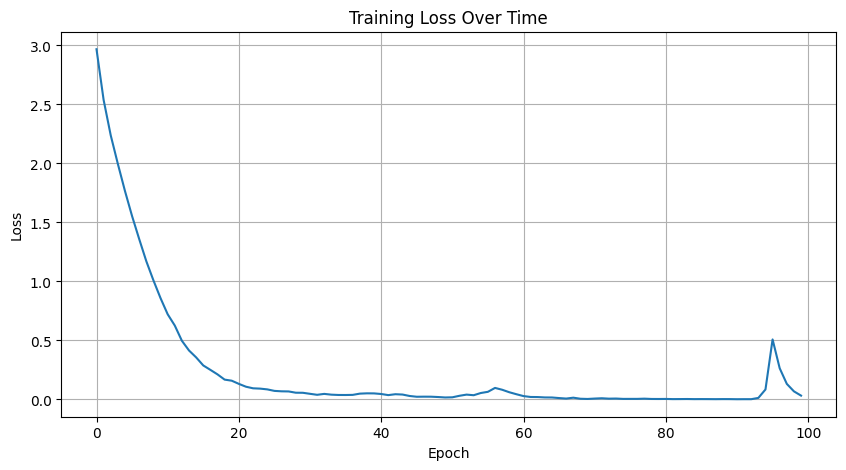

In [7]:
def train_model(model, X, y, epochs=50, batch_size=64, print_every=10):
    """
    Train the LSTM model on character sequences.
    """
    model.train()
    losses = []

    # Create data loader
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print("Starting training...")
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        for batch_X, batch_y in dataloader:
            # Move to device
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output, _ = model(batch_X)

            # Calculate loss
            loss = criterion(output, batch_y)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            # Update weights
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        if epoch % print_every == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}")

    return losses

# Train the model
EPOCHS = 100
BATCH_SIZE = 32

losses = train_model(model_lstm, X, y, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Cell 7: Text Generation with LSTM

In [8]:
def generate_text(model, tokenizer, seed_text, predict_len=200, temperature=0.8):
    """
    Generate text using the trained LSTM model.

    Parameters:
    - model: trained LSTM model
    - tokenizer: character tokenizer
    - seed_text: initial text to start generation
    - predict_len: number of characters to generate
    - temperature: controls randomness (0.1=conservative, 1.0=creative, >1.0=random)
    """
    model.eval()

    # Prepare seed text
    if len(seed_text) < SEQUENCE_LENGTH:
        # Pad with spaces if seed is too short
        seed_text = ' ' * (SEQUENCE_LENGTH - len(seed_text)) + seed_text
    else:
        seed_text = seed_text[-SEQUENCE_LENGTH:]

    generated = seed_text
    input_seq = torch.tensor(tokenizer.encode(seed_text), dtype=torch.long).unsqueeze(0).to(device)

    # Initialize hidden state
    hidden = model.init_hidden(1)

    # Warm up the model with seed text
    with torch.no_grad():
        for i in range(len(seed_text) - 1):
            _, hidden = model(input_seq[:, i:i+1], hidden)

    # Generate new characters
    current_input = input_seq[:, -1:]

    with torch.no_grad():
        for _ in range(predict_len):
            # Get prediction
            output, hidden = model(current_input, hidden)

            # Apply temperature scaling
            output_dist = output.data.view(-1).div(temperature).exp()

            # Sample from the distribution
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add to generated text
            predicted_char = tokenizer.idx_to_char[top_i.item()]
            generated += predicted_char

            # Prepare next input
            current_input = torch.tensor([[top_i]], dtype=torch.long).to(device)

    return generated

# Generate text with different seeds and temperatures
print("=" * 60)
print("LSTM TEXT GENERATION RESULTS")
print("=" * 60)

seeds = [
    "artificial intelligence",
    "machine learning",
    "deep learning",
    "natural language"
]

for seed in seeds:
    print(f"\n--- Seed: '{seed}' ---")
    generated = generate_text(model_lstm, tokenizer, seed, predict_len=150, temperature=0.8)
    print(generated)
    print("-" * 50)

# Try different temperatures
print("\n" + "=" * 60)
print("EFFECT OF TEMPERATURE ON GENERATION")
print("=" * 60)
seed = "neural networks"
for temp in [0.5, 0.8, 1.0, 1.2]:
    print(f"\nTemperature: {temp}")
    generated = generate_text(model_lstm, tokenizer, seed, predict_len=100, temperature=temp)
    print(generated[:150] + "...")

LSTM TEXT GENERATION RESULTS

--- Seed: 'artificial intelligence' ---
                           artificial intelligence.
intelligent tutoring systems personalize learning.
automated grading saves time for teachers.
online education platforms use recommendation systems.
--------------------------------------------------

--- Seed: 'machine learning' ---
                                  machine learning allows systems to improve automatically with experience.
data plays a critical role in training intelligent systems personalize learning.
automated g
--------------------------------------------------

--- Seed: 'deep learning' ---
                                     deep learning.
automated grading saves time for teachers.
online education platforms use recommendation systems.
technology enhances the quality of learning experi
--------------------------------------------------

--- Seed: 'natural language' ---
                                  natural language processing helps compute

In [9]:
# Save the model
torch.save({
    'model_state_dict': model_lstm.state_dict(),
    'char_to_idx': tokenizer.char_to_idx,
    'idx_to_char': tokenizer.idx_to_char,
    'vocab_size': tokenizer.vocab_size,
    'embed_dim': EMBED_DIM,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS
}, '/content/lstm_text_generation_model.pth')

print("Model saved successfully!")

# To load the model later:
"""
checkpoint = torch.load('/content/lstm_text_generation_model.pth')
tokenizer_loaded = CharTokenizer("")  # Empty init
tokenizer_loaded.char_to_idx = checkpoint['char_to_idx']
tokenizer_loaded.idx_to_char = checkpoint['idx_to_char']
tokenizer_loaded.vocab_size = checkpoint['vocab_size']
tokenizer_loaded.chars = list(checkpoint['char_to_idx'].keys())

model_loaded = CharLSTM(
    vocab_size=checkpoint['vocab_size'],
    embed_dim=checkpoint['embed_dim'],
    hidden_dim=checkpoint['hidden_dim'],
    num_layers=checkpoint['num_layers']
).to(device)
model_loaded.load_state_dict(checkpoint['model_state_dict'])
"""

Model saved successfully!


'\ncheckpoint = torch.load(\'/content/lstm_text_generation_model.pth\')\ntokenizer_loaded = CharTokenizer("")  # Empty init\ntokenizer_loaded.char_to_idx = checkpoint[\'char_to_idx\']\ntokenizer_loaded.idx_to_char = checkpoint[\'idx_to_char\']\ntokenizer_loaded.vocab_size = checkpoint[\'vocab_size\']\ntokenizer_loaded.chars = list(checkpoint[\'char_to_idx\'].keys())\n\nmodel_loaded = CharLSTM(\n    vocab_size=checkpoint[\'vocab_size\'],\n    embed_dim=checkpoint[\'embed_dim\'],\n    hidden_dim=checkpoint[\'hidden_dim\'],\n    num_layers=checkpoint[\'num_layers\']\n).to(device)\nmodel_loaded.load_state_dict(checkpoint[\'model_state_dict\'])\n'

Component II: Transformer Based Text Generation
Cell 9: Transformer Setup

In [10]:
# For Transformer, we'll use a simplified version due to memory constraints
# We'll use word-level tokenization for better efficiency

import re
from collections import Counter

class WordTokenizer:
    """
    Word-level tokenizer for Transformer model.
    Handles unknown words with <UNK> token.
    """
    def __init__(self, text, max_vocab_size=500):
        # Clean and split text into words
        words = re.findall(r'\b\w+\b|[^\w\s]', text.lower())

        # Count word frequencies
        word_counts = Counter(words)

        # Keep most common words
        most_common = word_counts.most_common(max_vocab_size - 3)  # Reserve spots for special tokens

        # Build vocabulary with special tokens
        self.vocab = ['<PAD>', '<UNK>', '<EOS>'] + [word for word, _ in most_common]
        self.word_to_idx = {word: i for i, word in enumerate(self.vocab)}
        self.idx_to_word = {i: word for i, word in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)

        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Most common words: {self.vocab[3:13]}")

    def encode(self, text):
        """Convert text to list of word indices"""
        words = re.findall(r'\b\w+\b|[^\w\s]', text.lower())
        return [self.word_to_idx.get(word, self.word_to_idx['<UNK>']) for word in words]

    def decode(self, indices):
        """Convert indices back to text"""
        words = [self.idx_to_word.get(idx, '<UNK>') for idx in indices]
        return ' '.join(words)

# Create word-level tokenizer
word_tokenizer = WordTokenizer(text_corpus, max_vocab_size=300)

# Encode text
encoded_words = word_tokenizer.encode(text_corpus)
print(f"\nTotal words: {len(encoded_words)}")
print(f"First 20 words: {encoded_words[:20]}")
print(f"Decoded: {word_tokenizer.decode(encoded_words[:20])}")

Vocabulary size: 198
Most common words: ['.', 'and', 'in', 'is', 'models', 'are', 'the', 'learning', 'systems', 'data']

Total words: 340
First 20 words: [18, 19, 6, 45, 30, 46, 3, 47, 6, 31, 5, 48, 49, 20, 4, 50, 3, 51, 10, 32]
Decoded: artificial intelligence is transforming modern society . it is used in healthcare finance education and transportation . machine learning allows


Cell 10: Transformer Components

In [11]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding for Transformer.
    Adds position information to embeddings since Transformer has no recurrence.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate angles
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-np.log(10000.0) / d_model)
        )

        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer (not a parameter, but saved with model)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Add positional encoding to input embeddings.
        x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerBlock(nn.Module):
    """
    Single Transformer Encoder Block.
    Consists of Multi-Head Attention and Feed-Forward Network.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()

        # Multi-Head Self-Attention
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout, batch_first=True)

        # Feed-Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )

        # Layer Normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-Attention with residual connection
        attn_output, _ = self.attention(x, x, x, attn_mask=mask, need_weights=False)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-Forward with residual connection
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

class TransformerLanguageModel(nn.Module):
    """
    Transformer-based Language Model for text generation.
    Simplified version suitable for educational purposes.
    """
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2,
                 d_ff=256, max_seq_len=50, dropout=0.1):
        super(TransformerLanguageModel, self).__init__()

        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # Token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_seq_len)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Output layer
        self.fc = nn.Linear(d_model, vocab_size)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights for stable training"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        """
        Forward pass through Transformer.
        x: (batch_size, seq_len) - token indices
        """
        # Create causal mask (prevent looking at future tokens)
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)

        # Embedding and positional encoding
        x = self.embedding(x) * np.sqrt(self.d_model)  # Scale embeddings
        x = self.pos_encoder(x)
        x = self.dropout(x)

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            x = block(x, mask)

        # Output projection (only use last position for prediction)
        output = self.fc(x[:, -1, :])  # (batch_size, vocab_size)

        return output

    def generate(self, tokenizer, seed_text, max_length=30, temperature=0.8):
        """
        Generate text using the trained Transformer.
        """
        self.eval()
        device = next(self.parameters()).device

        # Encode seed
        input_ids = tokenizer.encode(seed_text)

        # Truncate if too long
        if len(input_ids) > self.max_seq_len:
            input_ids = input_ids[-self.max_seq_len:]

        generated_words = tokenizer.encode(seed_text)

        with torch.no_grad():
            for _ in range(max_length):
                # Prepare input
                input_tensor = torch.tensor([input_ids[-self.max_seq_len:]], dtype=torch.long).to(device)

                # Get prediction
                output = self(input_tensor)

                # Apply temperature and sample
                probs = torch.softmax(output / temperature, dim=-1)
                next_token = torch.multinomial(probs, 1).item()

                # Stop if end token
                if next_token == tokenizer.word_to_idx.get('<EOS>', next_token):
                    break

                generated_words.append(next_token)
                input_ids.append(next_token)

        return tokenizer.decode(generated_words)

# Initialize Transformer model
D_MODEL = 128
NUM_HEADS = 4
NUM_LAYERS = 2
D_FF = 256
MAX_SEQ_LEN = 30  # Shorter for memory efficiency

model_transformer = TransformerLanguageModel(
    vocab_size=word_tokenizer.vocab_size,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    d_ff=D_FF,
    max_seq_len=MAX_SEQ_LEN,
    dropout=0.1
).to(device)

print(model_transformer)
print(f"\nTotal parameters: {sum(p.numel() for p in model_transformer.parameters()):,}")

TransformerLanguageModel(
  (embedding): Embedding(198, 128)
  (pos_encoder): PositionalEncoding()
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=198, bias=True)
)

Total parameters: 315,846


Cell 11: Prepare Transformer Data

In [12]:
def create_word_sequences(encoded_words, seq_length):
    """
    Create sequences for word-level training.
    """
    X, y = [], []
    for i in range(len(encoded_words) - seq_length):
        X.append(encoded_words[i:i + seq_length])
        y.append(encoded_words[i + seq_length])
    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Create word sequences
WORD_SEQ_LEN = 20  # Shorter sequences for Transformer
X_words, y_words = create_word_sequences(encoded_words, WORD_SEQ_LEN)

print(f"Total sequences: {len(X_words)}")
print(f"Input shape: {X_words.shape}")
print(f"Example input: {word_tokenizer.decode(X_words[0].tolist())}")
print(f"Example target: '{word_tokenizer.idx_to_word[y_words[0].item()]}'")

Total sequences: 320
Input shape: torch.Size([320, 20])
Example input: artificial intelligence is transforming modern society . it is used in healthcare finance education and transportation . machine learning allows
Example target: 'systems'


Cell 12: Train Transformer Model

Training Transformer...
Epoch [10/100], Loss: 0.4973, LR: 0.001000
Epoch [20/100], Loss: 0.0264, LR: 0.000500
Epoch [30/100], Loss: 0.0046, LR: 0.000500
Epoch [40/100], Loss: 0.0223, LR: 0.000250
Epoch [50/100], Loss: 0.0010, LR: 0.000250
Epoch [60/100], Loss: 0.0007, LR: 0.000125
Epoch [70/100], Loss: 0.0004, LR: 0.000125
Epoch [80/100], Loss: 0.0007, LR: 0.000063
Epoch [90/100], Loss: 0.0002, LR: 0.000063
Epoch [100/100], Loss: 0.0001, LR: 0.000031


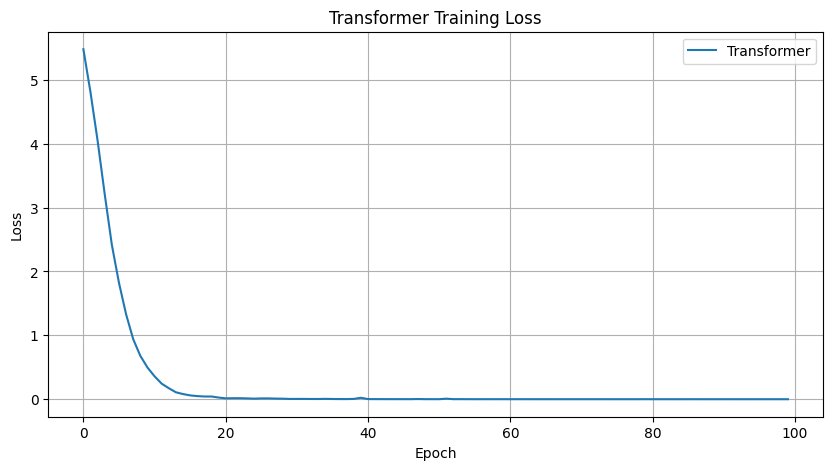

In [13]:
def train_transformer(model, X, y, epochs=50, batch_size=32, lr=0.001):
    """
    Train the Transformer model.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    losses = []
    model.train()

    print("Training Transformer...")
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            output = model(batch_X)
            loss = criterion(output, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    return losses

# Train
TRANSFORMER_EPOCHS = 100
transformer_losses = train_transformer(model_transformer, X_words, y_words,
                                      epochs=TRANSFORMER_EPOCHS, batch_size=16)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(transformer_losses, label='Transformer')
plt.title('Transformer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Cell 13: Generate Text with Transformer

In [14]:
print("=" * 60)
print("TRANSFORMER TEXT GENERATION RESULTS")
print("=" * 60)

test_seeds = [
    "artificial intelligence is",
    "machine learning allows",
    "deep learning uses",
    "neural networks are"
]

for seed in test_seeds:
    print(f"\n--- Seed: '{seed}' ---")
    generated = model_transformer.generate(
        word_tokenizer,
        seed,
        max_length=25,
        temperature=0.8
    )
    print(generated)
    print("-" * 50)

# Compare temperatures
print("\n" + "=" * 60)
print("TEMPERATURE COMPARISON (Transformer)")
print("=" * 60)

seed = "natural language processing"
for temp in [0.5, 0.8, 1.0]:
    print(f"\nTemperature: {temp}")
    generated = model_transformer.generate(word_tokenizer, seed, max_length=20, temperature=temp)
    print(generated)

TRANSFORMER TEXT GENERATION RESULTS

--- Seed: 'artificial intelligence is' ---
artificial intelligence is being improved systems to improve ai systems to improve automatically with experience . online education platforms use recommendation systems . technology enhances the quality of
--------------------------------------------------

--- Seed: 'machine learning allows' ---
machine learning allows systems . large datasets help models are slow for teachers . large datasets help models can create stories poems and produces an of learning experiences
--------------------------------------------------

--- Seed: 'deep learning uses' ---
deep learning uses multi layer neural networks are inspired by biological neurons . each neuron processes input and produces an output . training a neural network requires optimization
--------------------------------------------------

--- Seed: 'neural networks are' ---
neural networks are slow for teachers . training a neural networks are or character .

Cell 14: Comparison and Analysis

In [15]:
def calculate_perplexity(model, X, y, model_type='lstm'):
    """
    Calculate perplexity as a measure of model quality.
    Lower perplexity = better model.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='sum')
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for i in range(0, len(X), 32):
            batch_X = X[i:i+32].to(device)
            batch_y = y[i:i+32].to(device)

            if model_type == 'lstm':
                output, _ = model(batch_X)
            else:
                output = model(batch_X)

            loss = criterion(output, batch_y)
            total_loss += loss.item()
            total_tokens += len(batch_y)

    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    return perplexity

# Calculate perplexities
print("Calculating model perplexities...")
print("Lower perplexity indicates better prediction performance.\n")

try:
    lstm_ppl = calculate_perplexity(model_lstm, X, y, 'lstm')
    print(f"LSTM Perplexity: {lstm_ppl:.2f}")
except Exception as e:
    print(f"LSTM Perplexity calculation error: {e}")

try:
    transformer_ppl = calculate_perplexity(model_transformer, X_words, y_words, 'transformer')
    print(f"Transformer Perplexity: {transformer_ppl:.2f}")
except Exception as e:
    print(f"Transformer Perplexity calculation error: {e}")

# Manual quality assessment
print("\n" + "=" * 60)
print("QUALITATIVE ANALYSIS")
print("=" * 60)

print("""
LSTM Model Characteristics:
- Sequential processing (slower but memory efficient)
- Good at capturing local patterns
- Struggles with very long dependencies
- Character-level: Can learn spelling and basic grammar

Transformer Model Characteristics:
- Parallel processing (faster training)
- Better at long-range dependencies via attention
- Requires more memory
- Word-level: Better semantic coherence but limited vocabulary
""")

Calculating model perplexities...
Lower perplexity indicates better prediction performance.

LSTM Perplexity: 1.01
Transformer Perplexity: 1.00

QUALITATIVE ANALYSIS

LSTM Model Characteristics:
- Sequential processing (slower but memory efficient)
- Good at capturing local patterns
- Struggles with very long dependencies
- Character-level: Can learn spelling and basic grammar

Transformer Model Characteristics:
- Parallel processing (faster training)
- Better at long-range dependencies via attention
- Requires more memory
- Word-level: Better semantic coherence but limited vocabulary



Cell 15: Interactive Demo

In [16]:
def interactive_generation():
    """
    Interactive text generation demo.
    Run this cell and input your own seed text!
    """
    print("Interactive Text Generation Demo")
    print("=" * 50)
    print("1. LSTM Model (Character-level)")
    print("2. Transformer Model (Word-level)")
    print("=" * 50)

    choice = input("Select model (1 or 2): ").strip()

    if choice == '1':
        seed = input("Enter seed text (at least 20 chars recommended): ").strip()
        length = int(input("Generation length (characters): "))
        temp = float(input("Temperature (0.1-1.5): "))

        print("\nGenerating...")
        result = generate_text(model_lstm, tokenizer, seed, length, temp)
        print("\nGenerated Text:")
        print(result)

    elif choice == '2':
        seed = input("Enter seed text (3-5 words recommended): ").strip()
        length = int(input("Generation length (words): "))
        temp = float(input("Temperature (0.1-1.5): "))

        print("\nGenerating...")
        result = model_transformer.generate(word_tokenizer, seed, length, temp)
        print("\nGenerated Text:")
        print(result)

    else:
        print("Invalid choice!")

# Uncomment to run interactive demo:
# interactive_generation()

# Or run automatic examples:
print("Running automatic examples...\n")

examples = [
    "the future of artificial intelligence",
    "students should learn",
    "data privacy is important"
]

print("LSTM Examples:")
for ex in examples:
    print(f"\nSeed: '{ex}'")
    print(generate_text(model_lstm, tokenizer, ex, 100, 0.8)[:150])

print("\n\nTransformer Examples:")
for ex in examples:
    print(f"\nSeed: '{ex}'")
    print(model_transformer.generate(word_tokenizer, ex, 15, 0.8))

Running automatic examples...

LSTM Examples:

Seed: 'the future of artificial intelligence'
             the future of artificial intelligence.
intelligent tutoring systems personalize learning.
automated grading saves time for teachers.
onli

Seed: 'students should learn'
                             students should learning is essential in the field of ai.
research and innovation drive technological progress.
students 

Seed: 'data privacy is important'
                         data privacy is important for ai engineers.
practical experimentation enhances understanding.
human judgement is often requir


Transformer Examples:

Seed: 'the future of artificial intelligence'
the <UNK> of artificial intelligence . programming skills are major concerns . intelligent systems personalize learning and articles . programming

Seed: 'students should learn'
students should learn . evaluation of learning is essential in the field of ai . students should be

Seed: 'data privacy is important'
data